In [451]:
using DataFrames
using Requests
using TimeSeries
using MarketTechnicals
using PyPlot

In [452]:
# function csvtotimearray0(url)
#     df = readtable(Requests.get_streaming(url))
#     timestamp = Date[Date(i) for i in df[1]] # parse dates
#     colnames=AbstractString[string(i) for i in DataFrames.names(df)]
#     dataarray=convert(Array, df[2:end])
#     TimeArray(timestamp,dataarray,colnames[2:end])
# end
function csvtotimearray(url, count=Void)
    df = readtable(Requests.get_streaming(url))
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=AbstractString[string(i) for i in DataFrames.names(df)]
    offset=(Void==count||count<1||count>length(DataFrames.names(df))-1)?(length(DataFrames.names(df))-2):(count-1)
    dataarray=convert(Array, df[end-offset:end])
    TimeArray(timestamp,dataarray,colnames[end-offset:end])
end
function yahoo(symbol, startdate)
    str="a=$(Dates.month(startdate)-1)"*Dates.format(startdate, "&b=dd&c=yyyy")
    url="http://real-chart.finance.yahoo.com/table.csv?s="*symbol*"&"*str*"&g=d&ignore=.csv"
    csvtotimearray(url)
end
function quandl(symbol, startdate, count=Void)
    str=Dates.format(startdate, "yyyy-mm-dd")
    url="https://www.quandl.com/api/v3/datasets/$symbol.csv?api_key=VKyXNok9WfyAwAHtZBCR&start_date=$str"
    csvtotimearray(url, count)
end
function renameseries(series, columns)
    TimeArray(series.timestamp,series.values,columns)
end

renameseries (generic function with 1 method)

In [453]:
startdate=Date(2007,11,1) # set an early date to make use of all CBOE/GVZ data
symbol="SPY"
# ohlcv=yahoo(symbol, startdate)
ohlcv=quandl("YAHOO/INDEX_SPY", startdate)

2153x6 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-20

             Open      High      Low       Close     Volume          Adjusted_Close  
2007-11-01 | 153.29    153.41    150.59    151.03    333040800       126.2755        
2007-11-02 | 151.53    152.0     149.21    151.2     331228200       126.4176        
2007-11-05 | 149.64    151.16    148.97    150.05    226841000       125.4561        
2007-11-06 | 150.86    152.11    149.9     152.07    177800500       127.145         
⋮
2016-05-17 | 206.46    206.8     204.23    204.85    109782900       204.85          
2016-05-18 | 204.44    206.3     203.63    204.91    120062100       204.91          
2016-05-19 | 204.06    204.54    202.78    204.2     114063200       204.2           
2016-05-20 | 204.92    206.1     204.86    205.49    102475000       205.49          


In [454]:
predictcount=252
rangelength=42
ta=ohlcv["Close"];

In [455]:
gold=quandl("WGC/GOLD_DAILY_USD", startdate)
goldarray=TimeArray(gold.timestamp,gold.values./gold.values[1],["WGC/GOLD_DAILY_USD"])

2232x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-20

             WGC/GOLD_DAILY_USD  
2007-11-01 | 1.0                 
2007-11-02 | 1.0079              
2007-11-05 | 1.0184              
2007-11-06 | 1.0408              
⋮
2016-05-17 | 1.6159              
2016-05-18 | 1.6108              
2016-05-19 | 1.5771              
2016-05-20 | 1.5871              


In [456]:
ustreasuryarray=renameseries(quandl("USTREASURY/REALLONGTERM", startdate), ["USTREASURY/REALLONGTERM"])

2140x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-20

             USTREASURY/REALLONGTERM  
2007-11-01 | 2.12                     
2007-11-02 | 2.05                     
2007-11-05 | 2.06                     
2007-11-06 | 2.07                     
⋮
2016-05-17 | 0.61                     
2016-05-18 | 0.7                      
2016-05-19 | 0.71                     
2016-05-20 | 0.71                     


In [457]:
tyvixarray=renameseries(quandl("CBOE/TYVIX", startdate, 1), ["CBOE/TYVIX"])

2156x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-20

             CBOE/TYVIX  
2007-11-01 | 6.17        
2007-11-02 | 6.5         
2007-11-05 | 6.46        
2007-11-06 | 6.45        
⋮
2016-05-17 | 5.38        
2016-05-18 | 5.56        
2016-05-19 | 5.55        
2016-05-20 | 5.27        


In [458]:
eurusdarray=renameseries(quandl("ECB/EURUSD", startdate), ["ECB/EURUSD"])

2188x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-20

             ECB/EURUSD  
2007-11-01 | 1.4423      
2007-11-02 | 1.4479      
2007-11-05 | 1.4488      
2007-11-06 | 1.4547      
⋮
2016-05-17 | 1.1318      
2016-05-18 | 1.1279      
2016-05-19 | 1.1197      
2016-05-20 | 1.1219      


In [459]:
vixarray=renameseries(quandl("CBOE/VIX", startdate)["VIX_Close"], ["CBOE/VIX"])

2152x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-11-01 to 2016-05-19

             CBOE/VIX  
2007-11-01 | 23.21     
2007-11-02 | 23.01     
2007-11-05 | 24.31     
2007-11-06 | 21.39     
⋮
2016-05-16 | 14.68     
2016-05-17 | 15.57     
2016-05-18 | 15.95     
2016-05-19 | 16.33     


In [460]:
vxnarray=renameseries(quandl("CBOE/VXN", startdate)["Close"], ["CBOE/VXN"])

2152x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-11-01 to 2016-05-19

             CBOE/VXN  
2007-11-01 | 26.26     
2007-11-02 | 24.83     
2007-11-05 | 26.1      
2007-11-06 | 23.91     
⋮
2016-05-16 | 16.37     
2016-05-17 | 17.6      
2016-05-18 | 17.41     
2016-05-19 | 17.88     


In [461]:
ovxarray=renameseries(quandl("CBOE/OVX", startdate), ["CBOE/OVX"]) # CBOE/OVX since 2007-05-10

2153x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-19

             CBOE/OVX  
2007-11-01 | 39.71     
2007-11-02 | 39.99     
2007-11-05 | 40.14     
2007-11-06 | 41.2      
⋮
2016-05-16 | 42.03     
2016-05-17 | 42.75     
2016-05-18 | 42.87     
2016-05-19 | 42.4      


In [462]:
evzarray=renameseries(quandl("CBOE/EVZ", startdate), ["CBOE/EVZ"]) # CBOE/EVZ since 2007-11-01

2145x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-19

             CBOE/EVZ  
2007-11-01 | 8.09      
2007-11-02 | 8.12      
2007-11-05 | 7.98      
2007-11-06 | 8.18      
⋮
2016-05-16 | 9.14      
2016-05-17 | 9.18      
2016-05-18 | 9.88      
2016-05-19 | 10.01     


In [463]:
gvzarray=renameseries(quandl("CBOE/GVZ", startdate), ["CBOE/GVZ"]) # CBOE/GVZ since 2008-6-3

LoadError: LoadError: Saw 1424 rows, 1 columns and 2847 fields
 * Line 1 has 4 columns

while loading In[463], in expression starting on line 1

In [464]:
oilarray=renameseries(quandl("OPEC/ORB", startdate), ["OPEC/ORB"])

LoadError: LoadError: Saw 1507 rows, 1 columns and 3013 fields
 * Line 1 has 4 columns

while loading In[464], in expression starting on line 1

In [465]:
ushybondarray=renameseries(quandl("ML/HYOAS", startdate), ["ML/HYOAS"])
usaabondarray=renameseries(quandl("ML/AAOAS", startdate), ["ML/AAOAS"])
usyieldspreadarray=renameseries(ushybondarray.-usaabondarray, ["ML/HYOAS-ML/AAOAS"])

2231x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-11-01 to 2016-05-19

             ML/HYOAS-ML/AAOAS  
2007-11-01 | 3.24               
2007-11-02 | 3.31               
2007-11-05 | 3.28               
2007-11-06 | 3.24               
⋮
2016-05-16 | 5.42               
2016-05-17 | 5.38               
2016-05-18 | 5.29               
2016-05-19 | 5.41               


In [466]:
aaii_weekly=quandl("AAII/AAII_SENTIMENT", startdate)

447x12 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-01 to 2016-05-19

             Bullish  Neutral  Bearish  Total   Bullish_8_Week_Mov_Avg  Bull_Bear_Spread  Bullish_Average  Bullish_Average_St_Dev  Bullish_Average_St_Dev_1  S_P_500_Weekly_High  S_P_500_Weekly_Low  S_P_500_Weekly_Close  
2007-11-01 | 0.4471   0.1882   0.3647   1.0     0.4412                  0.0824            0.3853           0.4885                  0.282                     1551.91              1529.42             1549.38               
2007-11-08 | 0.3619   0.1238   0.5143   1.0     0.4365                  -0.1524           0.3853           0.4885                  0.282                     1519.49              1475.08             1475.62               
2007-11-15 | 0.3301   0.1748   0.4951   1.0     0.4287                  -0.165            0.3853           0.4885                  0.282                     1491.51              1466.99             1470.58               
2007-11-22 | 0.2558   0.2171   0.5271   1.

In [467]:
usleading_weekly=quandl("ECRI/USLEADING", startdate)

446x2 TimeSeries.TimeArray{Float64,2,DataType} 2007-11-02 to 2016-05-13

             Level     Growth   
2007-11-02 | 139.5752  -1.1373  
2007-11-09 | 139.6104  -1.4609  
2007-11-16 | 138.408   -2.0029  
2007-11-23 | 136.2959  -3.0796  
⋮
2016-04-22 | 135.4442  4.4144   
2016-04-29 | 135.6165  5.3268   
2016-05-06 | 134.9601  5.599    
2016-05-13 | 134.4896  5.3018   


In [468]:
function overlaps(t1::Vector, t2::Vector)
    i = j = 1
    idx1 = Int[]
    idx2 = Int[]
    while i <= length(t1) && j <= length(t2)
        if t1[i] > t2[j]
            j += 1
        elseif t1[i] < t2[j]
            i += 1
        else
            push!(idx1, i)
            push!(idx2, j)
            i += 1
            j += 1
        end
    end
    (idx1, idx2)        
end
function merge2(ta1, ta2)
    idx1, idx2 = overlaps(ta1.timestamp, ta2.timestamp)
    vals = [ta1[idx1].values ta2[idx2].values]
    TimeArray(ta1[idx1].timestamp, vals, [ta1.colnames; ta2.colnames])
end

merge2 (generic function with 1 method)

In [469]:
function weekly_to_daily(weekly, daily)
    width=length(weekly.colnames)
    merged=merge2(weekly,daily)
    series=daily[merged.timestamp[1]:merged.timestamp[end]]
    sentiment=zeros(length(series),length(merged.colnames))
    for i in merged.timestamp
        idx1=searchsortedfirst(series.timestamp,i)
        idx2=searchsortedfirst(merged.timestamp,i)
        sentiment[idx1,:]=merged.values[idx2,:]
    end
#     # linear interpolation of 2 adjacent values
#     for i=2:length(merged.timestamp)
#         i1=merged.timestamp[i-1]
#         i2=merged.timestamp[i]
#         idx1=searchsortedfirst(series.timestamp,i1)
#         idx2=searchsortedfirst(series.timestamp,i2)
#         span=idx2-idx1
#         d=1/span
#         ds=collect(linspace(d,1-d,span-1))
#         for i=1:length(ds)
#             alpha=ds[i]
#             sentiment[idx1+i,:]=(1-alpha).*sentiment[idx1,:].+alpha.*sentiment[idx2,:]
#         end
#     end
#     last=searchsortedfirst(series.timestamp,merged.timestamp[end])
    last=1
    for i=last+1:size(sentiment,1)
        if sentiment[i,1]==0
            sentiment[i,:]=sentiment[i-1,:]
        end
    end
    TimeArray(series.timestamp,sentiment[:,1:width],merged.colnames[1:width])
end
function pad_daily(weekly, daily)
    merged=weekly_to_daily(weekly, daily)
    idx=searchsortedfirst(daily.timestamp, merged.timestamp[end])
    times=daily.timestamp[idx+1:end]
    n=length(times)
    if n>0
        values=merged.values[end,:]
        for i=2:n
            values=[values merged.values[end,:]]
        end
        values=transpose(values)
        TimeArray([merged.timestamp;times], [merged.values;values], merged.colnames)
    else
        TimeArray(merged.timestamp, merged.values, merged.colnames)
    end
end
# # extend a 1D series with its last element
# function padseries(short, long, columns=Void)
#     times=long.timestamp[searchsortedfirst(long.timestamp,short.timestamp[end])+1:end]
#     TimeArray([short.timestamp;times], [short.values;fill(short.values[end], length(times))], columns==Void?short.colnames:columns)
# end

pad_daily (generic function with 1 method)

In [470]:
aaii=pad_daily(aaii_weekly, vixarray)
aaiiarray=TimeArray(aaii.timestamp, aaii.values[:,[1:3;5:6]], ["AAII/AAII_SENTIMENT.Bullish","AAII/AAII_SENTIMENT.Neutral","AAII/AAII_SENTIMENT.Bearish","AAII.Bullish_8_Week_Mov_Avg","AAII.Bull_Bear_Spread"])
usleadingarray=renameseries(pad_daily(usleading_weekly, vixarray), ["ECRI/USLEADING.Level", "ECRI/USLEADING.Growth"]);

In [471]:
function aroon(ta, n=25)
    up=moving(ta,x->findlast(x,maximum(x))/length(x),n)
    down=moving(ta,x->findlast(x,minimum(x))/length(x),n)
    d=up.-down
    r=merge2(up,down)
    r=merge2(r,d)
    TimeArray(r.timestamp,r.values,["aroon$n.up","aroon$n.down","aroon$n.up-down"])
end

aroon (generic function with 2 methods)

In [472]:
function volumeoscillator(ohlcv, n=28, c="Volume")
    volume=ohlcv[c]
    vshort=ema(volume, int(n/2))
    vlong=ema(volume, n)
    volumeoscillator=(vshort.-vlong)./vlong
    TimeArray(volumeoscillator.timestamp,volumeoscillator.values,["VolumeOscillator$n"])
end

volumeoscillator (generic function with 3 methods)

In [473]:
function chaikinmoneyflow(ohlcv, n=21, h="High", l="Low", c="Close", v="Volume")
    high=ohlcv[h]
    low=ohlcv[l]
    clo=ohlcv[c]
    volume=ohlcv[v]
    moneyflowvolume = (2.*clo.-low.-high)./(high.-low).*volume
    moneyflowsum=moving(moneyflowvolume,sum,n)
    volumesum=moving(volume,sum,n)
    re=moneyflowsum./volumesum
    TimeArray(re.timestamp, re.values, ["cmf$n"], ohlcv.meta)
end

chaikinmoneyflow (generic function with 6 methods)

In [474]:
function bollingerbands2{T,N}(ta::TimeArray{T,N}, ma::Int, width::Real)
    tama   = sma(ta, ma)
    upband = tama .+ moving(ta, std, ma) .* width .* sqrt((ma-1)/ma) # take out Bessel correction, per algorithm
    dnband = tama .- moving(ta, std, ma) .* width .* sqrt((ma-1)/ma)
    bands  =  merge(upband, dnband) 
    merge(bands, tama, col_names = ["up", "down", "mean"])
end
function bollingerbands_deviation(ta, n=20, width=2)
    bbands=bollingerbands2(ta,n,width)
    bbprice=merge2(bbands,ta)
    bbstd=(bbands.values[:,1].-bbands.values[:,3])./2
    bbdev=(bbprice.values[:,4].-bbands.values[:,3])./(bbands.values[:,1].-bbands.values[:,3])
    TimeArray(bbands.timestamp, [bbdev bbstd], ["bbdev$n,$width", "bbstd$n,$width"])
end
function bollingerbands_all(ta, n=20, width=2)
#     b0=bollingerbands_deviation(ta, int(n/2), width)
    b1=bollingerbands_deviation(ta, n, width)
    b2=bollingerbands_deviation(ta, n*2, width)
#     r=merge2(b0,b1)
    merge2(b1,b2)
end

bollingerbands_all (generic function with 3 methods)

In [475]:
function vwap_divergence(ohlcv, n=28)
    v1=vwap(ohlcv, int(n/2))
    v2=vwap(ohlcv, n)
    v3=vwap(ohlcv, n*2)
    v4=vwap(ohlcv, n*4)
    d1=v1.-v2
    d2=v2.-v3
    d3=v3.-v4
    ta=merge2(v1,v2)
    ta=merge2(ta,v3)
    ta=merge2(ta,v4)
    ta=merge2(ta,d1)
    ta=merge2(ta,d2)
    ta=merge2(ta,d3)
    cname=["vwap$(int(n/2))","vwap$n","vwap$(n*2)","vwap$(n*4)","vwap$(int(n/2))-$n","vwap$n-$(n*2)","vwap$(n*2)-$(n*4)"]#,"vwap$(n*8)","vwap$(n*4)-$(n*8)"]
    TimeArray(ta.timestamp,ta.values,cname)
end

vwap_divergence (generic function with 2 methods)

In [476]:
function averagetruerange(ohlc, n=14, h="High", l="Low", c="Close")
    highs = merge(ohlc[h], lag(ohlc[c]))
    lows = merge(ohlc[l], lag(ohlc[c]))
    hi=convert(Array{Float64,1},[maximum(highs.values[i,:]) for i=1:size(highs.values)[1]])
    lo=convert(Array{Float64,1},[minimum(lows.values[i,:]) for i=1:size(lows.values)[1]])
    truehigh = TimeArray(highs.timestamp, hi, ["hi"], highs.meta)
    truelow  = TimeArray(lows.timestamp, lo, ["lo"], lows.meta)
    res = ema(truehigh .- truelow, n, wilder=true)
    TimeArray(res.timestamp, res.values, ["atr$n"], ohlc.meta)
end
function atr_divergence(ohlcv, n=28)
    v1=averagetruerange(ohlcv,int(n/2));
    v2=averagetruerange(ohlcv,n);
    v3=averagetruerange(ohlcv,n*2);
    v4=averagetruerange(ohlcv,n*4);
    d1=v1.-v2
    d2=v2.-v3
    d3=v3.-v4
    ta=merge2(v1,v2)
    ta=merge2(ta,v3)
    ta=merge2(ta,v4)
    ta=merge2(ta,d1)
    ta=merge2(ta,d2)
    ta=merge2(ta,d3)
    cname=["atr$(int(n/2))","atr$n","atr$(n*2)","atr$(n*4)","atr$(int(n/2))-$n","atr$n-$(n*2)","atr$(n*2)-$(n*4)"]#,"atr$(n*8)","atr$(n*4)-$(n*8)"]
    TimeArray(ta.timestamp,ta.values,cname)
end

atr_divergence (generic function with 2 methods)

In [477]:
function moneyflowindex(ohlcv, n=14, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{Float64,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{Float64,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pv=TimeArray(diff.timestamp,positive,["Positive"]).*volume
    nv=TimeArray(diff.timestamp,negative,["Negative"]).*volume
    psum=moving(pv,sum,n)
    nsum=moving(nv,sum,n)
    re=psum./(psum.+nsum)
    TimeArray(re.timestamp, re.values, ["mfi$n"], ohlcv.meta)
end
function rsi_mfi_divergence(rsi, mfi, n=14)
    signal=ema(mfi.-rsi,5)
    TimeArray(signal.timestamp,signal.values,["rsi_mfi_divergence"])
end
function rsi_mfi_all(ohlcv, n=28, c="Close")
    ta=ohlcv[c]
    r1=rsi(ta,n)./100
    m1=moneyflowindex(ohlcv,n)
    merge2(r1,m1)
end

rsi_mfi_all (generic function with 3 methods)

In [478]:
# function ChandeMomentumOscillator(ohlcv, n=9, h="High", l="Low", c="Close")
#     hi=ohlcv[h]
#     lo=ohlcv[l]
#     cl=ohlcv[c]
#     typical=(hi.+lo.+cl)./3
#     diff=typical.-lag(typical)
#     positive=convert(Array{Real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
#     negative=convert(Array{Real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
#     pv=TimeArray(diff.timestamp,positive,["Positive"])
#     nv=TimeArray(diff.timestamp,negative,["Negative"])
#     psum=moving(pv,sum,n)
#     nsum=moving(nv,sum,n)
#     re=(psum.-nsum)./(psum.+nsum)
#     TimeArray(re.timestamp, re.values, ["cmo$n"], ohlcv.meta)
# end
# function MoneyFlowOscillator(ohlcv, n=9, h="High", l="Low", c="Close", v="Volume")
#     hi=ohlcv[h]
#     lo=ohlcv[l]
#     cl=ohlcv[c]
#     volume=ohlcv[v]
#     typical=(hi.+lo.+cl)./3
#     diff=typical.-lag(typical)
#     positive=convert(Array{Real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
#     negative=convert(Array{Real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
#     pv=TimeArray(diff.timestamp,positive,["Positive"]).*volume
#     nv=TimeArray(diff.timestamp,negative,["Negative"]).*volume
#     psum=moving(pv,sum,n)
#     nsum=moving(nv,sum,n)
#     re=(psum.-nsum)./(psum.+nsum)
#     TimeArray(re.timestamp, re.values, ["mf$n"], ohlcv.meta)
# end
# function MoneyFlowDivergence(ohlcv, n=9, h="High", l="Low", c="Close", v="Volume")
#     cmo=ChandeMomentumOscillator(ohlcv, n)
#     mfo=MoneyFlowOscillator(ohlcv, n)
#     diff=mfo.-cmo
#     TimeArray(diff.timestamp,diff.values,["mfd$n"])
# end
# function mfo_all(ohlcv, n=9, signal=7, h="High", l="Low", c="Close", v="Volume")
#     mf1=MoneyFlowDivergence(ohlcv, int(n/2))
#     mf2=MoneyFlowDivergence(ohlcv, n)
#     d1=mf1.-mf2
#     re=ema(d1, signal)
#     TimeArray(re.timestamp,re.values,["mfo$n"])
# end

In [479]:
function macd2(ta, fast=12, slow=26, signal=9)
    mcd = ema(ta, fast) .- ema(ta, slow)
    sig = ema(mcd, signal)
    r = merge(mcd, sig, col_names=["macd($fast,$slow,$signal)", "signal"])
#     merge(r, mcd .- sig, col_names=[r.colnames; ["histogram"]])
end

macd2 (generic function with 4 methods)

In [480]:
function priceindex(ta, n=28)
    high=moving(ta, maximum, n)
    low=moving(ta, minimum, n)
    lh=merge(low, high, col_names = ["min", "max"])
    lh2=lh
    for i=1:n-1
        lh2=lead(lh2)
    end
    ranges=merge2(ta,lh2)
    index=[Real((i[2][1]-i[2][2])/(i[2][3]-i[2][2])) for i in ranges]
    TimeArray(ranges.timestamp, [ranges.values index], [ranges.colnames;["priceindex$n"]])
end

priceindex (generic function with 2 methods)

In [481]:
rsimfiarray=rsi_mfi_all(ohlcv,rangelength);
macdarray=macd2(ta,int(rangelength/2),rangelength);
vwaparray=vwap_divergence(ohlcv,rangelength);
atrarray=atr_divergence(ohlcv,rangelength);
aroonarray=aroon(ta,rangelength);
volumeoscillatorarray=volumeoscillator(ohlcv,rangelength);
cmfarray=chaikinmoneyflow(ohlcv,rangelength);
bbarray=bollingerbands_all(ta,rangelength,2);
# mfoarray=mfo_all(ohlcv, int(rangelength/2));
priceindexarray=priceindex(ta,rangelength);

 [inlined code] from ./error.jl:26
 in depwarn(::ASCIIString, ::Symbol) at ./deprecated.jl:64
 in int(::Float64) at ./deprecated.jl:50
 in vwap_divergence(::TimeSeries.TimeArray{Float64,2,DataType}, ::Int64) at ./In[475]:2
 [inlined code] from ./essentials.jl:82
 in include_string(::ASCIIString, ::ASCIIString) at ./loading.jl:371
 in execute_request_0x535c5df2(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.5/IJulia/src/execute_request.jl:177
 [inlined code] from ./dict.jl:779
 in eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.5/IJulia/src/IJulia.jl:141
 in (::IJulia.##24#30)() at ./task.jl:308
while loading In[481], in expression starting on line 3
 [inlined code] from ./error.jl:26
 in depwarn(::ASCIIString, ::Symbol) at ./deprecated.jl:64
 in int(::Float64) at ./deprecated.jl:50
 in vwap_divergence(::TimeSeries.TimeArray{Float64,2,DataType}, ::Int64) at ./In[475]:15
 [inlined code] from ./essentials.jl:82
 in include_string(::ASCIIString, ::ASCIIString) at ./l

In [482]:
featurearray=merge2(bbarray,cmfarray);
# featurearray=merge2(featurearray,mfoarray);
featurearray=merge2(featurearray,macdarray);
featurearray=merge2(featurearray,volumeoscillatorarray);
featurearray=merge2(featurearray,rsimfiarray);
featurearray=merge2(featurearray,atrarray);
featurearray=merge2(featurearray,vwaparray);
featurearray=merge2(featurearray,aroonarray);
featurearray=merge2(featurearray,ustreasuryarray);
featurearray=merge2(featurearray,ushybondarray);
featurearray=merge2(featurearray,usaabondarray);
featurearray=merge2(featurearray,usyieldspreadarray);
featurearray=merge2(featurearray,tyvixarray);
featurearray=merge2(featurearray,vixarray);
featurearray=merge2(featurearray,vxnarray);
featurearray=merge2(featurearray,goldarray);
featurearray=merge2(featurearray,gvzarray);
featurearray=merge2(featurearray,oilarray);
featurearray=merge2(featurearray,ovxarray);
featurearray=merge2(featurearray,eurusdarray);
featurearray=merge2(featurearray,evzarray);
featurearray=merge2(featurearray,aaiiarray);
featurearray=merge2(featurearray,usleadingarray);

 [inlined code] from ./error.jl:26
 in depwarn(::ASCIIString, ::Symbol) at ./deprecated.jl:64
 in int(::Float64) at ./deprecated.jl:50
 in volumeoscillator(::TimeSeries.TimeArray{Float64,2,DataType}, ::Int64, ::ASCIIString) at ./In[472]:3
 in volumeoscillator(::TimeSeries.TimeArray{Float64,2,DataType}, ::Int64) at ./In[472]:2
 [inlined code] from ./essentials.jl:82
 in include_string(::ASCIIString, ::ASCIIString) at ./loading.jl:371
 in execute_request_0x535c5df2(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.5/IJulia/src/execute_request.jl:177
 [inlined code] from ./dict.jl:779
 in eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.5/IJulia/src/IJulia.jl:141
 in (::IJulia.##24#30)() at ./task.jl:308
while loading In[481], in expression starting on line 6


In [483]:
withlabel=merge2(featurearray,priceindexarray);

In [484]:
withoutlabel=merge2(featurearray,ta)

1949x48 TimeSeries.TimeArray{Float64,2,DataType} 2008-07-03 to 2016-05-19

             bbdev42,2  bbstd42,2  bbdev84,2  bbstd84,2  cmf42   macd(21,42,9)  signal  VolumeOscillator42  rsi     mfi42   atr21   atr42   atr84   atr168  atr21-42  atr42-84  atr84-168  vwap21    vwap42    vwap84    vwap168   vwap21-42  vwap42-84  vwap84-168  aroon42.up  aroon42.down  aroon42.up-down  USTREASURY/REALLONGTERM  ML/HYOAS  ML/AAOAS  ML/HYOAS-ML/AAOAS  CBOE/TYVIX  CBOE/VIX  CBOE/VXN  WGC/GOLD_DAILY_USD  CBOE/GVZ  OPEC/ORB  CBOE/OVX  ECB/EURUSD  CBOE/EVZ  AAII/AAII_SENTIMENT.Bullish  AAII/AAII_SENTIMENT.Neutral  AAII/AAII_SENTIMENT.Bearish  AAII.Bullish_8_Week_Mov_Avg  AAII.Bull_Bear_Spread  ECRI/USLEADING.Level  ECRI/USLEADING.Growth  Close     
2008-07-03 | -1.0529    4.768      -1.1073    4.2543     -0.1563 -2.4423        -1.7538 0.0881              0.3216  0.2476  2.1811  2.2541  2.4293  2.5455  -0.073    -0.1752   -0.1162    132.4194  135.4922  134.8917  137.9032  -3.0728    0.6005     -3.0115  

In [485]:
dataoffset=length(withoutlabel)-length(withlabel)
lastdate=withlabel.timestamp[end]
lastdateidx=searchsortedfirst(withoutlabel.timestamp, lastdate)
splitidx=lastdateidx-predictcount+dataoffset
newfeatures=TimeArray(withoutlabel.timestamp[splitidx+1:end],withoutlabel.values[splitidx+1:end,:],withoutlabel.colnames);

In [486]:
training=TimeArray(withlabel.timestamp[1:splitidx],withlabel.values[1:splitidx,:],withlabel.colnames);

In [487]:
test=TimeArray(withlabel.timestamp[splitidx+1:end],withlabel.values[splitidx+1:end,:],withlabel.colnames);

In [488]:
rsiidx=findfirst(withlabel.colnames, "rsi")
mfiidx=findfirst(withlabel.colnames, "mfi$rangelength")
bbsidx=findfirst(withlabel.colnames, "AAII.Bull_Bear_Spread")
pricerangeidx=findfirst(withlabel.colnames, "priceindex$rangelength")
closeidx=findfirst(withlabel.colnames, "Close")

48

In [489]:
randomfeaturenum=floor(Int,sqrt(closeidx))

6

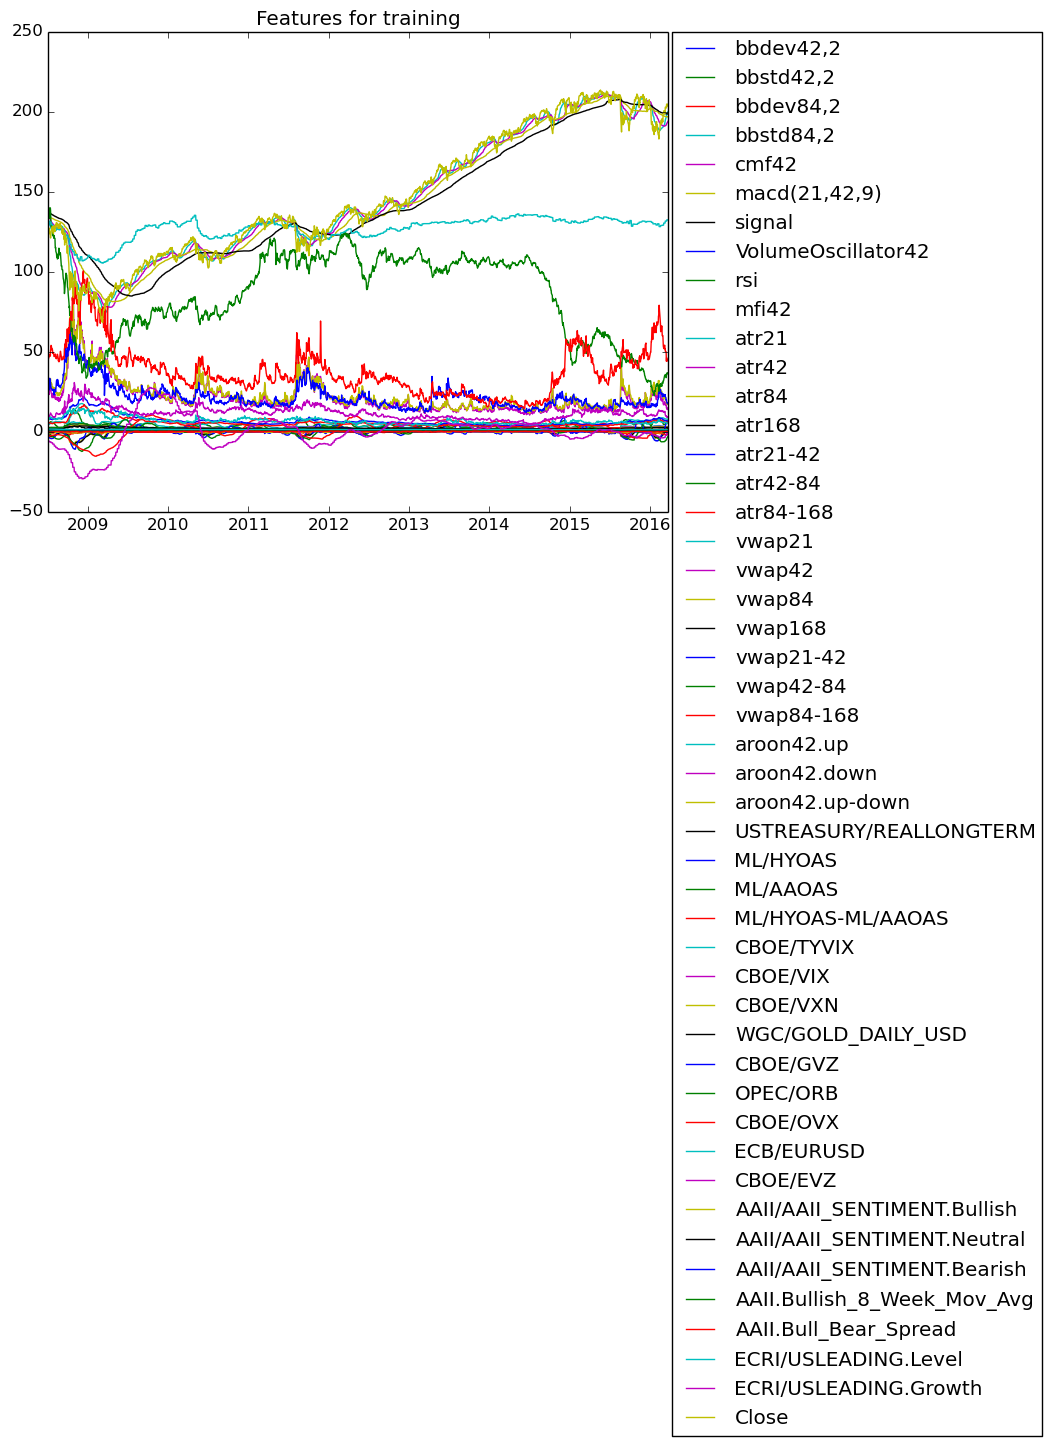

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [490]:
plot(withlabel.timestamp,withlabel.values[:,1:closeidx])
legend(withlabel.colnames[1:closeidx],bbox_to_anchor=(1.62, 1.02))
title("Features for training")

In [491]:
using DecisionTree
ntrees=100
features=training.values[:,1:closeidx]
labels=convert(Array{Float64,1},training.values[:,pricerangeidx])
# train regression forest, using 2 random features, 10 trees,
# averaging of 5 samples per leaf (optional), 0.7 of samples per tree (optional)
model = build_forest(labels, features, randomfeaturenum, ntrees, 5, 0.7)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 408.72
Avg Depth:  25.49

In [492]:
newlabels=apply_forest(model, newfeatures.values);
initvalue=withlabel.values[1,closeidx];

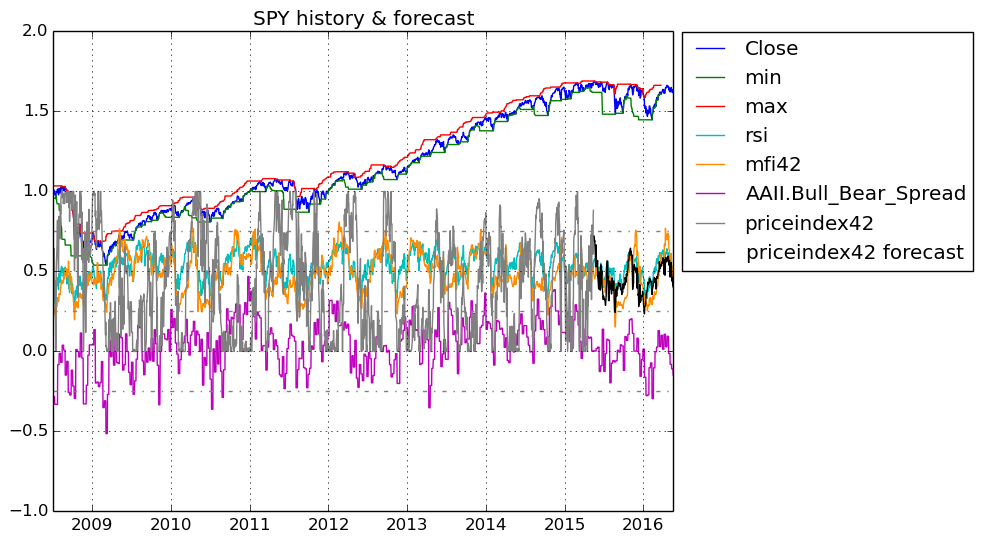

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [493]:
plot(withoutlabel.timestamp,withoutlabel.values[:,closeidx]./initvalue)
plot(withlabel.timestamp,withlabel.values[:,closeidx+1:closeidx+2]./initvalue)
plot(withoutlabel.timestamp,withoutlabel.values[:,rsiidx],c="c")
plot(withoutlabel.timestamp,withoutlabel.values[:,mfiidx],c="DarkOrange")
plot(withoutlabel.timestamp,withoutlabel.values[:,bbsidx],c="m")
plot(training.timestamp,training.values[:,pricerangeidx],c="Grey")
plot(newfeatures.timestamp,newlabels,c="k")
title("$symbol history & forecast")
grid("on")
axhline(y=-0.25,ls="-.",c="Grey")
axhline(y=0.25,ls="-.",c="Grey")
axhline(y=0.75,ls="-.",c="Grey")
legend([withlabel.colnames[[closeidx,closeidx+1,closeidx+2,rsiidx,mfiidx,bbsidx,pricerangeidx]];"priceindex$rangelength forecast"],bbox_to_anchor=(1.5, 1.02))

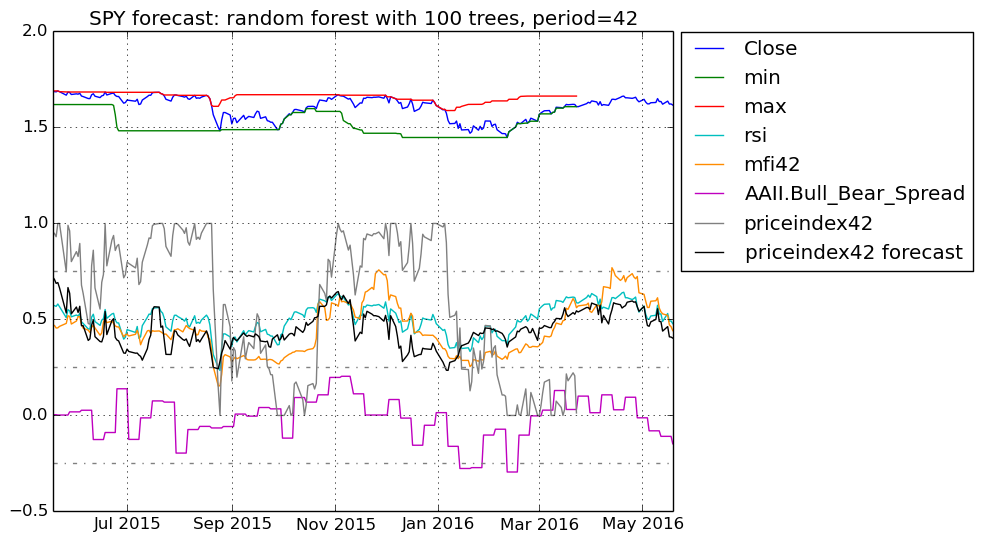

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [494]:
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue)
plot(test.timestamp,test.values[:,closeidx+1:closeidx+2]./initvalue)
plot(newfeatures.timestamp,newfeatures.values[:,rsiidx],c="c")
plot(newfeatures.timestamp,newfeatures.values[:,mfiidx],c="DarkOrange")
plot(newfeatures.timestamp,newfeatures.values[:,bbsidx],c="m")
plot(test.timestamp,test.values[:,pricerangeidx],c="Grey")
plot(newfeatures.timestamp,newlabels,c="k")
legend([test.colnames[[closeidx,closeidx+1,closeidx+2,rsiidx,mfiidx,bbsidx,pricerangeidx]];"priceindex$rangelength forecast"],bbox_to_anchor=(1.5, 1.02))
title("$symbol forecast: random forest with $ntrees trees, period=$rangelength")
grid("on")
# color names http://astropython.blogspot.ie/2012/02/additional-color-names-for-matplotlib.html
# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.axhline
axhline(y=-0.25,ls="-.",c="Grey")
axhline(y=0.25,ls="-.",c="Grey")
axhline(y=0.75,ls="-.",c="Grey")

In [495]:
features=withlabel.values[:,1:closeidx]
labels=convert(Array{Float64,1},withlabel.values[:,pricerangeidx])
# run n-fold cross validation on regression forest
# using 2 random features, 10 trees, 3 folds, averaging of 5 samples/leaf (optional),
# and 0.7 porition of samples per tree (optional)
# returns array of coefficients of determination (R^2)
r2 = nfoldCV_forest(labels, features, 2, ntrees, 3, 5, 0.7)


Fold 1
Mean Squared Error:     0.01708557712437345
Correlation Coeff:      0.9462933768052656
Coeff of Determination: 0.8477710603667785

Fold 2
Mean Squared Error:     0.015745642254096068
Correlation Coeff:      0.9467020678756564
Coeff of Determination: 0.8566708572406425

Fold 3

3-element Array{Float64,1}:
 0.847771
 0.856671
 0.849864


Mean Squared Error:     0.016488333084975333
Correlation Coeff:      0.9449036995171575
Coeff of Determination: 0.849863746181476

Mean Coeff of Determination: 0.8514352212629657
